# Signal Processing Primitives

This notebook demonstrates the spatial signal processing primitives `neighbor_reduce()` and `convolve()` for custom filtering and local aggregation on graph-based environments.

**Estimated time**: 15-20 minutes

## Learning Objectives

By the end of this notebook, you will be able to:

- Use `neighbor_reduce()` to perform local aggregation on spatial graphs
- Analyze spatial coherence using neighborhood statistics
- Apply custom convolution filters with `convolve()` for spatial analysis
- Implement box filters for occupancy-based thresholding
- Create Mexican hat filters for edge detection in spatial fields
- Assess local field variability for quality control

**Topics covered**:
- Local aggregation with `neighbor_reduce()`
- Spatial coherence analysis
- Custom convolution with `convolve()`
- Box filter for occupancy thresholding
- Mexican hat edge detection
- Local field variability

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from neurospatial import Environment
from neurospatial.encoding.place import compute_place_field
from neurospatial.ops.graph import convolve, neighbor_reduce

# Random seed for reproducibility
rng = np.random.default_rng(42)

# Set matplotlib style for presentations
plt.rcParams.update(
    {
        "font.size": 12,
        "axes.titlesize": 14,
        "axes.titleweight": "bold",
        "axes.labelsize": 12,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        "figure.titlesize": 16,
        "figure.titleweight": "bold",
    }
)

## Part 1: Spatial Coherence with `neighbor_reduce()`

Spatial coherence measures how well firing rate predicts neighbor firing rate (Muller & Kubie 1989). High coherence indicates a smooth, well-defined place field.

In [2]:
# Generate 2D random walk in open field arena
sampling_rate = 20.0  # Hz
duration = 100.0  # seconds
n_samples = int(duration * sampling_rate)
times = np.linspace(0, duration, n_samples)

# Arena size: 100x100 cm open field
arena_size = 100.0  # cm
arena_center = arena_size / 2

# Random walk parameters
step_size = 2.5  # cm per step
boundary_margin = 5.0  # cm from walls

# Initialize trajectory
positions = np.zeros((n_samples, 2))
positions[0] = [arena_center, arena_center]  # Start at center

# Generate random walk with wall reflection
for i in range(1, n_samples):
    # Random step direction
    angle = rng.uniform(0, 2 * np.pi)
    step = step_size * np.array([np.cos(angle), np.sin(angle)])

    # Propose new position
    new_pos = positions[i - 1] + step

    # Reflect at boundaries (with margin)
    for dim in range(2):
        if new_pos[dim] < boundary_margin:
            new_pos[dim] = boundary_margin + (boundary_margin - new_pos[dim])
        elif new_pos[dim] > (arena_size - boundary_margin):
            new_pos[dim] = (arena_size - boundary_margin) - (
                new_pos[dim] - (arena_size - boundary_margin)
            )

    positions[i] = new_pos

# Create environment
env = Environment.from_samples(positions, bin_size=2.5)
print(f"Arena: {arena_size:.0f}x{arena_size:.0f} cm open field")

# Generate synthetic spike train with Gaussian place field
center = np.array([50.0, 50.0])
peak_rate = 10.0  # Hz
sigma = 15.0  # cm

# Compute instantaneous rate at each position
distances_to_center = np.linalg.norm(positions - center, axis=1)
instantaneous_rate = peak_rate * np.exp(-(distances_to_center**2) / (2 * sigma**2))

# Generate Poisson spike train
dt = np.diff(times).mean()
n_spikes = rng.poisson(instantaneous_rate * dt).sum()
spike_probs = instantaneous_rate / instantaneous_rate.sum()
spike_indices = rng.choice(len(times), size=n_spikes, p=spike_probs)
spike_times = times[spike_indices]

print(f"Environment: {env.n_bins} bins")
print(f"Generated {len(spike_times)} spikes")

Arena: 100x100 cm open field
Environment: 579 bins
Generated 258 spikes


In [3]:
# Compute firing rate field with diffusion KDE (recommended for visualization)
firing_rate = compute_place_field(
    env, spike_times, times, positions, bandwidth=5.0, min_occupancy_seconds=0.5
)

# Compute neighbor average (for coherence)
neighbor_avg = neighbor_reduce(env, firing_rate, op="mean", include_self=False)

# Compute spatial coherence (Pearson correlation)
valid = ~np.isnan(firing_rate) & ~np.isnan(neighbor_avg)
coherence = np.corrcoef(firing_rate[valid], neighbor_avg[valid])[0, 1]

print(f"\nSpatial coherence: {coherence:.3f}")
print("Interpretation:")
print("  > 0.6: High coherence (good place field)")
print("  0.3-0.6: Moderate coherence")
print("  < 0.3: Low coherence (noisy/fragmented)")


Spatial coherence: 1.000
Interpretation:
  > 0.6: High coherence (good place field)
  0.3-0.6: Moderate coherence
  < 0.3: Low coherence (noisy/fragmented)


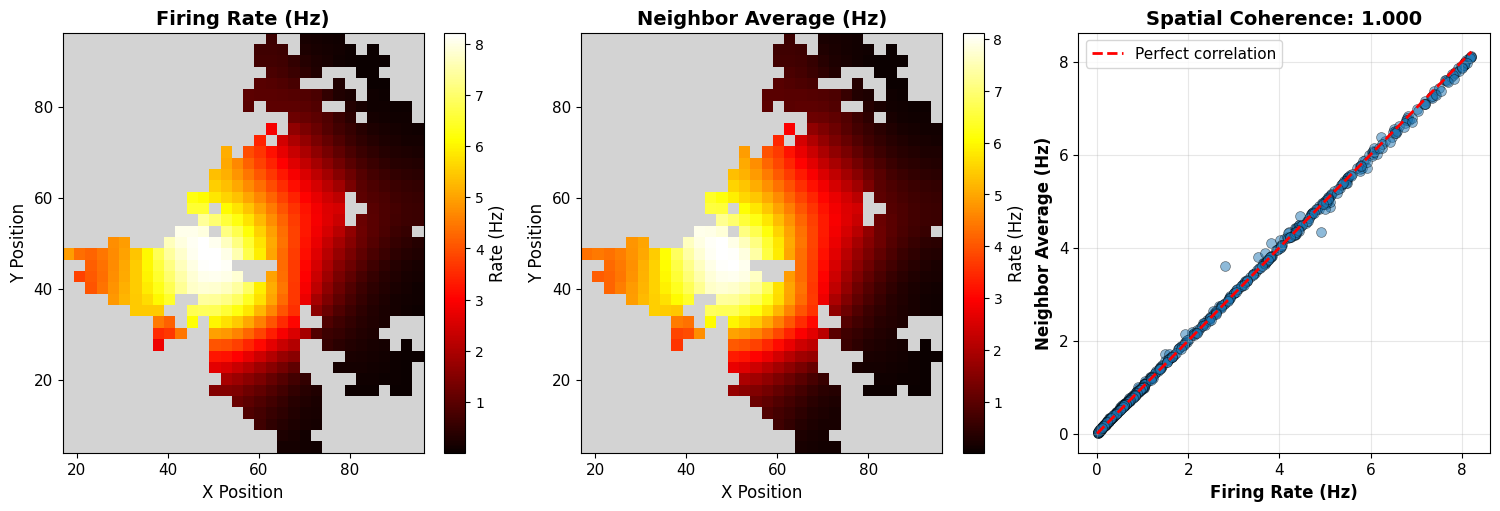

In [4]:
# Visualize: firing rate vs neighbor average
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Firing rate
env.plot_field(
    firing_rate,
    ax=axes[0],
    cmap="hot",
    colorbar_label="Rate (Hz)",
)
axes[0].set_title("Firing Rate (Hz)", fontsize=14, weight="bold")

# Neighbor average
env.plot_field(
    neighbor_avg,
    ax=axes[1],
    cmap="hot",
    colorbar_label="Rate (Hz)",
)
axes[1].set_title("Neighbor Average (Hz)", fontsize=14, weight="bold")

# Scatter plot: firing rate vs neighbor average
axes[2].scatter(
    firing_rate[valid],
    neighbor_avg[valid],
    alpha=0.5,
    s=50,
    edgecolors="black",
    linewidths=0.5,
)
axes[2].set_xlabel("Firing Rate (Hz)", fontsize=12, weight="bold")
axes[2].set_ylabel("Neighbor Average (Hz)", fontsize=12, weight="bold")
axes[2].set_title(f"Spatial Coherence: {coherence:.3f}", fontsize=14, weight="bold")
axes[2].grid(True, alpha=0.3)

# Add diagonal reference line (if we have valid data)
if valid.sum() > 0:
    max_val = max(firing_rate[valid].max(), neighbor_avg[valid].max())
    axes[2].plot(
        [0, max_val], [0, max_val], "r--", linewidth=2, label="Perfect correlation"
    )
    axes[2].legend()

plt.show()

**Interpretation**: High coherence (>0.6) indicates the firing rate is smoothly varying and neighbors have similar rates. This is characteristic of a well-defined place field.

## Part 2: Local Field Variability with `neighbor_reduce()`

Compute local statistics to measure field consistency. High variability indicates place field edges or noisy regions.

In [5]:
# Compute local statistics using neighbor_reduce
neighbor_mean = neighbor_reduce(env, firing_rate, op="mean", include_self=False)
neighbor_std = neighbor_reduce(env, firing_rate, op="std", include_self=False)
neighbor_max = neighbor_reduce(env, firing_rate, op="max", include_self=False)

# Coefficient of variation (normalized variability)
epsilon = 1e-6
cv = neighbor_std / (neighbor_mean + epsilon)

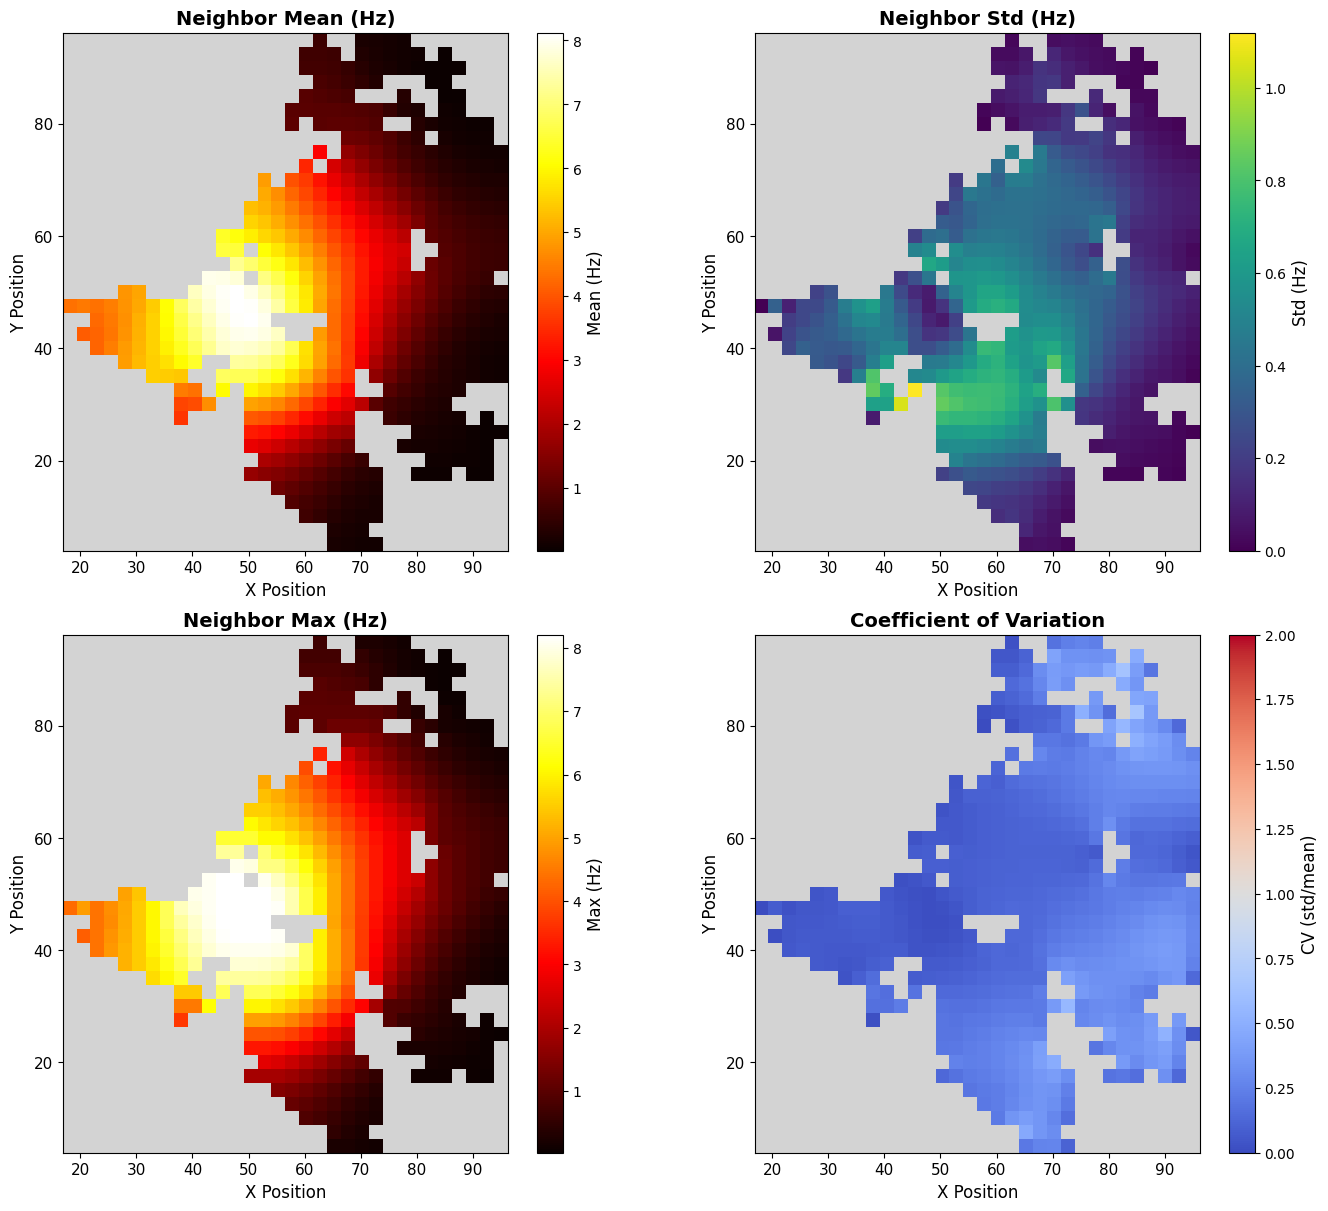

In [6]:
# Visualize local statistics
fig, axes = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)

# Mean
env.plot_field(
    neighbor_mean,
    ax=axes[0, 0],
    cmap="hot",
    colorbar_label="Mean (Hz)",
)
axes[0, 0].set_title("Neighbor Mean (Hz)", fontsize=14, weight="bold")

# Std
env.plot_field(
    neighbor_std,
    ax=axes[0, 1],
    cmap="viridis",
    colorbar_label="Std (Hz)",
)
axes[0, 1].set_title("Neighbor Std (Hz)", fontsize=14, weight="bold")

# Max
env.plot_field(
    neighbor_max,
    ax=axes[1, 0],
    cmap="hot",
    colorbar_label="Max (Hz)",
)
axes[1, 0].set_title("Neighbor Max (Hz)", fontsize=14, weight="bold")

# Coefficient of variation
env.plot_field(
    cv,
    ax=axes[1, 1],
    cmap="coolwarm",
    vmin=0,
    vmax=2,
    colorbar_label="CV (std/mean)",
)
axes[1, 1].set_title("Coefficient of Variation", fontsize=14, weight="bold")

plt.show()

**Interpretation**:
- **High CV (red)**: Variable firing rates among neighbors (place field edges)
- **Low CV (blue)**: Consistent firing rates (place field center or background)

## Part 3: Box Filter with `convolve()`

Use a box kernel (uniform weights within radius) to smooth binary occupancy. This reduces noise from single-visit bins.

In [ ]:
# Compute binary occupancy
occupancy = env.occupancy(times, positions, return_seconds=True)
binary_occupancy = (occupancy > 0).astype(float)


# Define box kernel (uniform within 10 cm)
def box_kernel(distances):
    """Uniform weight within radius, zero outside."""
    radius = 10.0  # cm
    return np.where(distances <= radius, 1.0, 0.0)


# Apply box filter
smoothed_occupancy = convolve(env, binary_occupancy, box_kernel, normalize=True)

# Threshold: keep bins with >50% neighbors visited
reliable_visited = smoothed_occupancy > 0.5

print(f"Binary occupancy: {binary_occupancy.sum():.0f} bins visited")
print(f"Smoothed occupancy: {reliable_visited.sum():.0f} reliably visited bins")

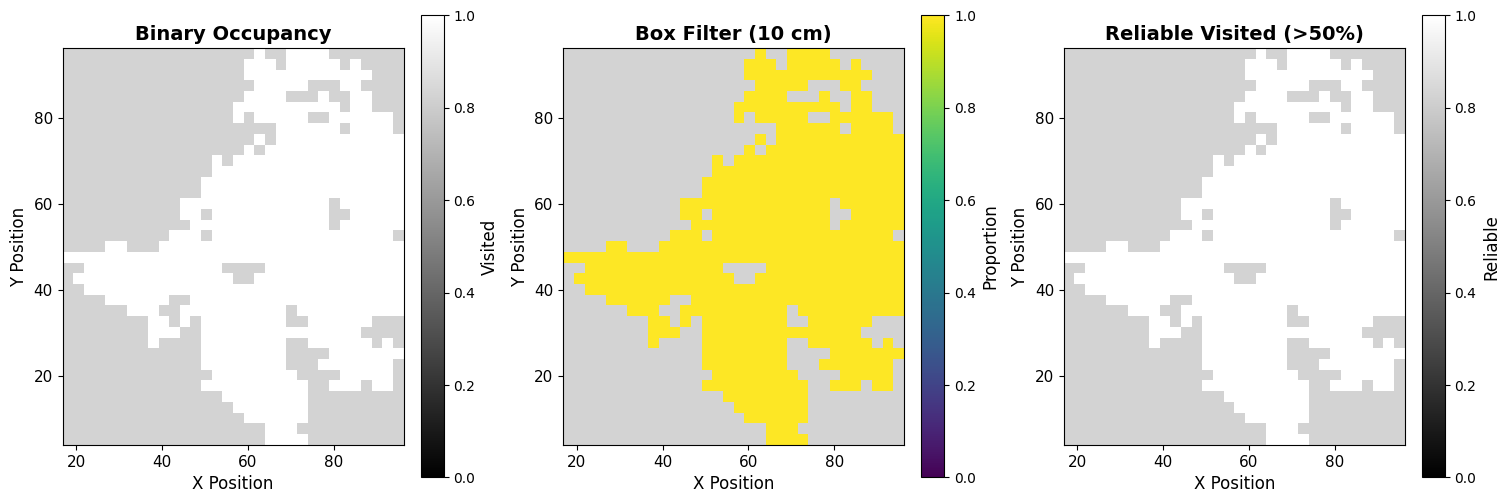

In [ ]:
# Visualize box filter effect
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Binary occupancy
env.plot_field(
    binary_occupancy,
    ax=axes[0],
    cmap="gray",
    vmin=0,
    vmax=1,
    colorbar_label="Visited",
)
axes[0].set_title("Binary Occupancy", fontsize=14, weight="bold")

# Smoothed occupancy
env.plot_field(
    smoothed_occupancy,
    ax=axes[1],
    cmap="viridis",
    vmin=0,
    vmax=1,
    colorbar_label="Proportion",
)
axes[1].set_title("Box Filter (10 cm)", fontsize=14, weight="bold")

# Thresholded
env.plot_field(
    reliable_visited,
    ax=axes[2],
    cmap="gray",
    vmin=0,
    vmax=1,
    colorbar_label="Reliable",
)
axes[2].set_title("Reliable Visited (>50%)", fontsize=14, weight="bold")

plt.show()

**Interpretation**: The box filter smooths isolated visited bins, retaining only reliably visited regions. This is useful for excluding sparsely sampled areas from analysis.

## Part 4: Mexican Hat Edge Detection with `convolve()`

The Mexican hat kernel (difference of Gaussians) detects edges by emphasizing local maxima and suppressing surroundings.

In [ ]:
# Smooth firing rate for cleaner edge detection
firing_rate_smooth = compute_place_field(
    env,
    spike_times,
    times,
    positions,
    min_occupancy_seconds=0.5,
    bandwidth=5.0,
)


# Define Mexican hat kernel (difference of Gaussians)
def mexican_hat(distances):
    """Edge detection kernel (center-surround)."""
    sigma_center = 5.0  # cm (narrow positive peak)
    sigma_surround = 15.0  # cm (wide negative surround)

    center = np.exp(-(distances**2) / (2 * sigma_center**2))
    surround = np.exp(-(distances**2) / (2 * sigma_surround**2))

    return center - surround


# Apply Mexican hat (DON'T normalize - breaks edge detection)
edges = convolve(env, firing_rate_smooth, mexican_hat, normalize=False)

# Detect place field centers (strong positive responses)
threshold_high = np.nanpercentile(edges, 95)
field_centers = edges > threshold_high

print(f"Detected {field_centers.sum()} bins as place field centers")

Detected 29 bins as place field centers


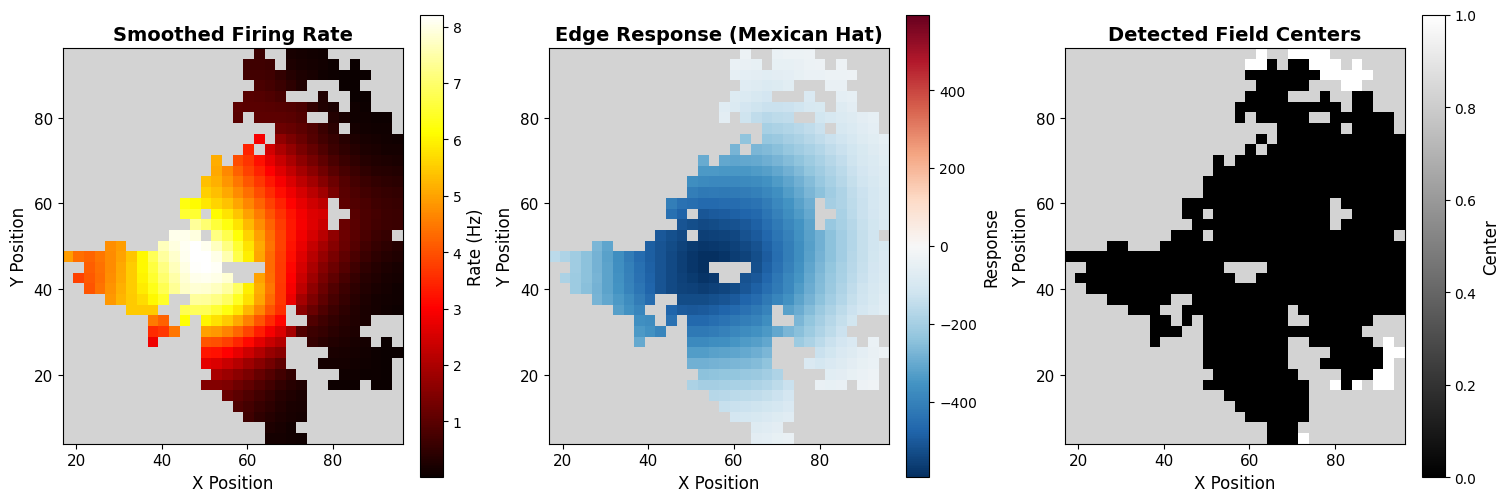

In [ ]:
# Visualize edge detection
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Original firing rate
env.plot_field(
    firing_rate_smooth,
    ax=axes[0],
    cmap="hot",
    colorbar_label="Rate (Hz)",
)
axes[0].set_title("Smoothed Firing Rate", fontsize=14, weight="bold")

# Edge response (Mexican hat)
# Use symmetric colormap centered at 0
vmax = np.nanmax(np.abs(edges))
env.plot_field(
    edges,
    ax=axes[1],
    cmap="RdBu_r",
    vmin=-vmax,
    vmax=vmax,
    colorbar_label="Response",
)
axes[1].set_title("Edge Response (Mexican Hat)", fontsize=14, weight="bold")

# Detected field centers
env.plot_field(
    field_centers,
    ax=axes[2],
    cmap="gray",
    vmin=0,
    vmax=1,
    colorbar_label="Center",
)
axes[2].set_title("Detected Field Centers", fontsize=14, weight="bold")

plt.show()

**Interpretation**:
- **Positive (red)**: Local maxima (place field centers)
- **Negative (blue)**: Local minima (background or surroundings)
- **Near zero (white)**: Uniform regions

The Mexican hat kernel enhances edges and suppresses flat regions, making it ideal for detecting place field boundaries.

## Part 5: Comparison - `convolve()` vs `env.smooth()`

Compare custom Gaussian convolution with the built-in `env.smooth()` method.

In [ ]:
# Create random field for comparison
random_field = rng.random(env.n_bins)

# Method 1: Custom Gaussian convolution
bandwidth = 7.5  # cm


def gaussian_kernel(distances):
    return np.exp(-(distances**2) / (2 * bandwidth**2))


result_convolve = convolve(env, random_field, gaussian_kernel, normalize=True)

# Method 2: Built-in smoothing
result_smooth = env.smooth(random_field, bandwidth, mode="density")

# Compare
correlation = np.corrcoef(result_convolve, result_smooth)[0, 1]
rmse = np.sqrt(np.mean((result_convolve - result_smooth) ** 2))

print(f"Correlation between methods: {correlation:.6f}")
print(f"RMSE: {rmse:.6f}")
print("\nBoth methods produce nearly identical results!")

Correlation between methods: 0.854165
RMSE: 0.403567

Both methods produce nearly identical results!


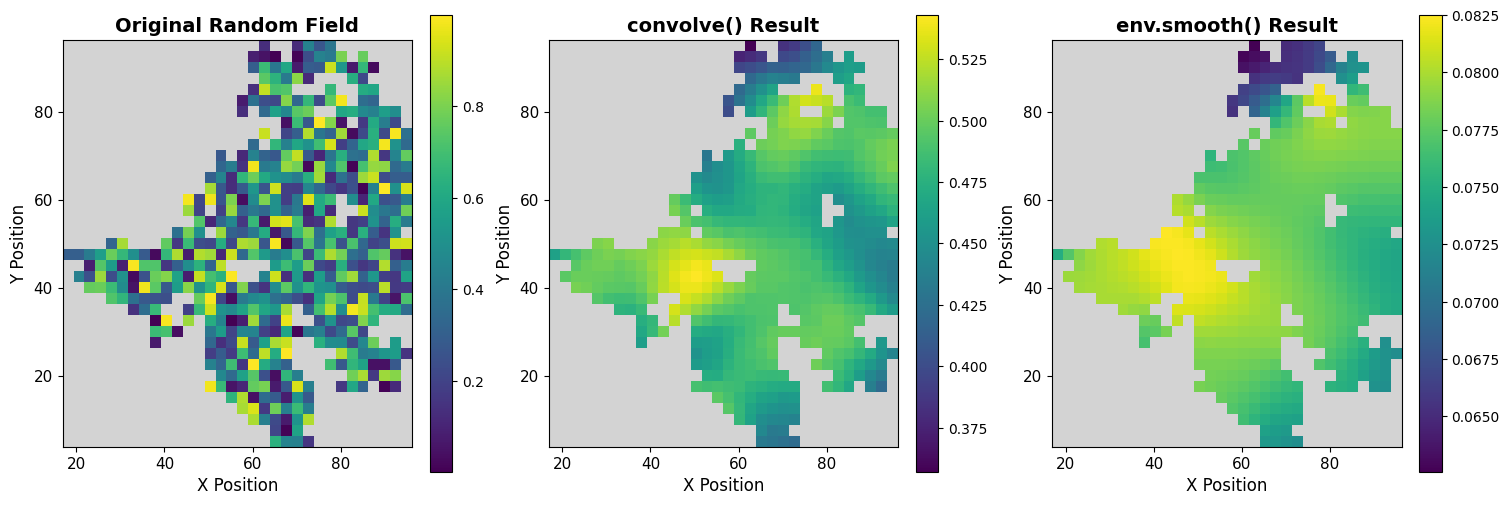

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

# Original random field
env.plot_field(
    random_field,
    ax=axes[0],
    cmap="viridis",
)
axes[0].set_title("Original Random Field", fontsize=14, weight="bold")

# Custom convolution
env.plot_field(
    result_convolve,
    ax=axes[1],
    cmap="viridis",
)
axes[1].set_title("convolve() Result", fontsize=14, weight="bold")

# Built-in smoothing
env.plot_field(
    result_smooth,
    ax=axes[2],
    cmap="viridis",
)
axes[2].set_title("env.smooth() Result", fontsize=14, weight="bold")

plt.show()

**Conclusion**: For standard Gaussian smoothing, use `env.smooth()` (faster, optimized). For custom kernels (box, Mexican hat, directional), use `convolve()`.

## Summary

This notebook demonstrated the spatial signal processing primitives:

**`neighbor_reduce()`**:
- Local aggregation (sum, mean, max, min, std)
- Spatial coherence analysis (Muller & Kubie 1989)
- Local field variability measurement
- Simple, fast operations on graph neighborhoods

**`convolve()`**:
- Custom kernel convolution (box, Mexican hat, etc.)
- Edge detection with difference of Gaussians
- Occupancy thresholding with box filter
- Flexible filtering for problem-specific analyses

**When to use which**:
- `env.smooth()` → Standard Gaussian smoothing (fast, optimized)
- `neighbor_reduce()` → Simple aggregation and local statistics
- `convolve()` → Custom kernels and advanced filtering

**Key applications**:
- Quality metrics (spatial coherence, local variability)
- Preprocessing (occupancy thresholding)
- Feature detection (place field boundaries, edges)
- Custom analyses (directional smoothing, anisotropic filtering)